## HW 1: Sinusoids, Functions, Additive Synthesis (15 points)
For each markdown cell, add a cell (or cells) of code below. 
Reminders:
* This is an individual assignment. 
* If you use GenAI tools to assist you with your homework, remember to fill out the GenAI Usage Statement at the bottom of the notebook. Even if you use GenAI, you should not be directly copying the code.
* You may only use functions/packages we have discussed in class

In [34]:
from IPython.display import Math, Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.io.wavfile import read
from IPython.display import Audio

### Question 1 - Sinusoids (3 points)
Define the function, **genSine(f, ...)** that construct a sinusoid at frequency `f`.
The arguments should include:  
* amplitude, with default value of 1 (float)
* sample rate, with default value of 44.1kHz (float)
* time in seconds, with default value of 1 (float)
* phase offset, with default value of 0 (float)
    
and will return the numpy array containing the sinusoidal waveform.

Your function must check for appropriate input and handle any errors.
    

In [35]:

def genSine(f, d=1, A=1, fs=44100, phi=(np.pi/2)):
    try:
        f  = float(f)
        d  = float(d)
        A  = float(A)
        fs = float(fs)
        phi = float(phi)
    except Exception:
        raise ValueError("All inputs must be numeric.")

    if f <= 0:
        raise ValueError("f must be a positive number (int or float).")
    if d <= 0:
        raise ValueError("d must be a positive number (int or float).")
    if fs <= 0:
        raise ValueError("fs must be a positive number (int or float).")

    t = np.arange(0.0, d, 1/fs)
    sine = A * np.cos(2*np.pi * f * t + phi)
    return sine


### Question 2 - Classical Waveform (5 points)
Define a function, **genWave(freq, t, numHarms=None, A=1, phi=0, fs=44100)**, that will create one of the fundamental waveforms (saw, triangle, or square) built from the combination of sinusoids at integer multiples of a fundamental frequency.  The arguments passed will be as follows:

* freq will be the frequency in Hz (int or float).
* t will be the length of time in seconds (int or float).
* numHarms will be the number of harmonics used. If no value is given (NoneType), you should create the maximum harmonics possible given the sampling rate

The function should return a numpy array. **You may not use existing waveform functions such as those in the `scipy` library.**

Your function must check for appropriate input and handle any errors.

Try to make your function as efficient as you can, but we will not take points off for a long run time. Be mindful by using NumPy functions rather than direct iteration.

*Hint: your function should use your genSine function

**Bonus: Expand this function to create any of the classical waveforms with a new argument "type" specifying which to build.

In [36]:
def genWave(freq, t, wave_type = 'square', numHarms=None, A=1, phi=0, fs=44100):
    if not ((type(freq) == int or type(freq) == float) and freq > 0):
        raise ValueError("freq must be a positive number (int or float).")
    if not ((type(t) == int or type(t) == float) and t > 0):
        raise ValueError("t must be a positive number (int or float).")
    if not ((type(fs) == int or type(fs) == float) and fs > 0):
        raise ValueError("fs must be a positive number (int or float).")
    if not (type(wave_type) == str and wave_type in ('square', 'saw', 'triangle')):
        raise ValueError("wave_type must be 'square', 'saw', or 'triangle'.")
    if numHarms is not None and not (type(numHarms) == int and numHarms >= 1):
        raise ValueError("numHarms must be a positive int or None.")
    
    nyq = fs / 2.0
    n_max = int((nyq - 1e-9) // freq)
    N = int(t * fs)
    if n_max < 1:
        return np.zeros(N, dtype=float)
    
    if wave_type == 'saw':
        harm = np.arange(1, n_max + 1)
    else:
        harm = np.arange(1, n_max + 1, 2)

    if numHarms is not None:
        harm = harm[:numHarms]
    if harm.size == 0:
        return np.zeros(N, dtype=float)
    
    
    phi_sine = phi - np.pi / 2.0
    y = np.zeros(N, dtype=float)

    
    if wave_type == 'square':
        for n in harm:
            y += genSine(n * freq, A=(A * 4.0 / np.pi) * (1.0 / n), fs=fs, d=t, phi=phi_sine)
    elif wave_type == 'saw':
        for n in harm:
            y += genSine(abs(n * freq), A=(A * 2.0 / np.pi) * ((-1) ** (n + 1)) * (1.0 / n), fs=fs, d=t, phi=phi_sine)
    else:
        for n in harm:
            k = (n - 1) // 2
            y += genSine(n * freq, A=(A * 8.0 / (np.pi ** 2)) * ((-1) ** k) * (1.0 / (n ** 2)), fs=fs, d=t, phi=phi_sine)

    return y

genWave(440, 2, wave_type='saw')



array([ 2.66341484e-17,  2.01093182e-02,  3.95995907e-02, ...,
       -6.03294258e-02, -3.95995907e-02, -2.01093182e-02])

### Question 3 - Arpeggio (4 points)

Define the function arpegiateFreq(freq, dur), that will create a major scale arpeggio of a given frequency for a given length using your genWave() function. The arguments passed will be as follows:
* freq will be the starting/fundamental frequency in Hz (int or float)
* dur will be the length of time in seconds (int or float)

Reminder: a major scale arpeggio is built from the root, major third, and perfect 5th. You should divide the duration evenly amongst the three notes. 

The function should return a numpy array.

*Hint: your function will use the function(s) you just wrote*

Your function must check for appropriate input and handle any errors

**Bonus: Create a new function called arpegiateNote(scale, dur). Instead of the second input being frequency in Hz, the function should receive a note name like 'C'. You will need to convert this note to frequency. If you want to go the extra mile, make it case sensitive, such that an uppercase 'C' yields a C major arpeggio and lowercase 'c' yields a c minor arpeggio.

In [37]:

def arpegiateFreq(freq, dur):
    if not ((type(freq) == int or type(freq) == float) and freq > 0):
        raise ValueError("freq must be a positive number (int or float).")
    if not ((type(dur) == int or type(dur) == float) and dur > 0):
        raise ValueError("dur must be a positive number (int or float).")

    fs = 44100
    note_dur = dur / 3.0

    f_root = freq
    f_m3 = freq * (2 ** (4/12))
    f_p5 = freq * (2 ** (7/12))

    y1 = genWave(f_root, note_dur, fs=fs, wave_type='square')
    y2 = genWave(f_m3,  note_dur, fs=fs, wave_type='square')
    y3 = genWave(f_p5,  note_dur, fs=fs, wave_type='square')

    return np.concatenate([y1, y2, y3])

arpegiateFreq(440, 3)

array([2.02020904e-16, 1.17910795e+00, 9.02566576e-01, ...,
       9.88445169e-01, 1.01048600e+00, 9.90490360e-01])

## Error handling tips and edge cases
What should happen if the frequency inputs to our functions would generate frequncies above Nyquist?

What should happen if our time inputs are negative? Or are 0?

What should happen if our frequencies are negative? Or are 0?

You should account for actual coding errors and errors that conceptually do not make sense.

### Section 4 - Using functions and graphing (3 points)
Create a 2 second F major arpeggio in an array named 'myArp'. Play back your audio.

In [38]:
myArp = arpegiateFreq(349.23, 2.0)
Audio(myArp, rate=44100)


Remove every 4th sample of 'myArp', save as a new array, 'skipped, and play back your audio. What happened to the audio?

In [39]:

skipped = np.delete(myArp, np.arange(3, myArp.size, 4))
Audio(skipped, rate=44100)

#1.5× faster, slightly higher pitch and more distortion

Create a 2 Bb major arpeggio in an array named 'myArp2'. Play back your audio

In [40]:
myArp2 = arpegiateFreq(466.16, 2)
Audio(myArp2, rate=44100)

Reverse 'myArp2' and save as a new array, 'reverse'. Play back your audio

In [41]:
reverse = np.flip(myArp2)
Audio(reverse, rate=44100)


Graph your 4 arrays on top of one another. Make sure to label the axis and plot against time. 

Text(0, 0.5, 'Amplitude')

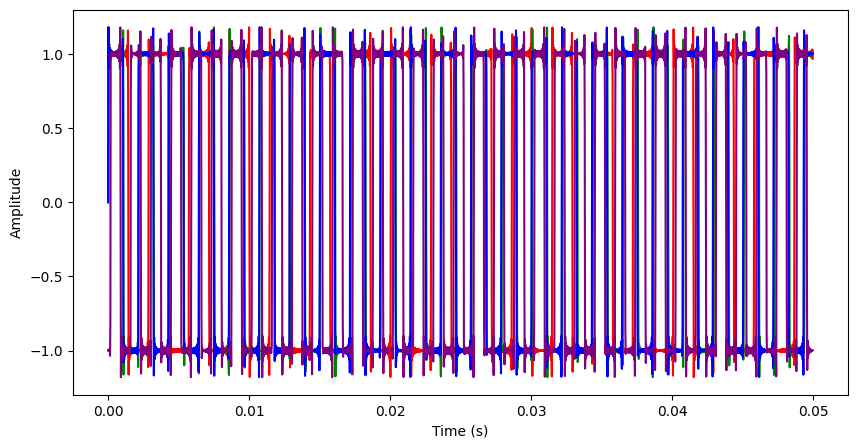

In [42]:
win = 0.05  # 50 ms
fs = 44100
N = int(win * fs)


t1 = np.arange(len(myArp))   / fs
t2 = np.arange(len(skipped)) / fs
t3 = np.arange(len(myArp2))  / fs
t4 = np.arange(len(reverse)) / fs

plt.figure(figsize=(10, 5))
plt.plot(t1[:N], myArp[:N], color = 'red')
plt.plot(t2[:N], skipped[:N], color = 'green')
plt.plot(t3[:N], myArp2[:N], color = 'blue')
plt.plot(t4[:N], reverse[:N], color = 'purple')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')



Create another graph, but this time only plot the first "note" of each array

Text(0.5, 1.0, 'First 50 ms of the First Note (All Arrays)')

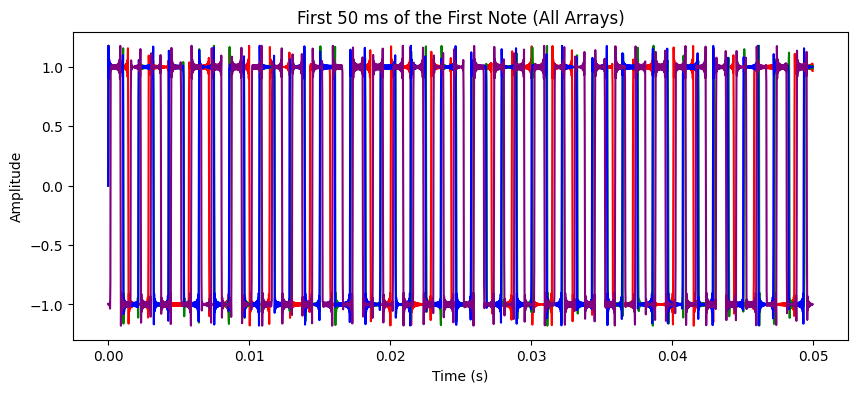

In [43]:

fs = 44100  

N1 = len(myArp)   // 3
N2 = len(skipped) // 3
N3 = len(myArp2)  // 3
N4 = len(reverse) // 3

win = 0.050 
W1 = min(int(win * fs), N1)
W2 = min(int(win * fs), N2)
W3 = min(int(win * fs), N3)
W4 = min(int(win * fs), N4)

t1 = np.arange(W1) / fs
t2 = np.arange(W2) / fs
t3 = np.arange(W3) / fs
t4 = np.arange(W4) / fs

plt.figure(figsize=(10, 4))
plt.plot(t1, myArp[:W1],   color='red')
plt.plot(t2, skipped[:W2], color='green')
plt.plot(t3, myArp2[:W3],  color='blue')
plt.plot(t4, reverse[:W4], color='purple')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('First 50 ms of the First Note (All Arrays)')


### GenAI Usage Statement (if applicable)

I used AI to help me find a way to change the graph so better see it.
I also used it to remind me the difference in the waveforms, so I knew how to code them different
I used it to help find the Hz of the notes for the arpeggiator
Used in genWave to help set x_max